I took `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detailed information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [ ]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 136 kB 46.8 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 43.6 MB/s 
     |████████████████████████████████| 1.1 MB 43.0 MB/s 
     |████████████████████████████████| 127 kB 50.5 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 10.7 MB/s 
     |████████████████████████████████| 144 kB 30.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 5.2 MB/s 


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('yahoo_answers_topics', revision='master') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Fine-tuning the model

In [ ]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [ ]:
!nvidia-smi

Sat Apr  2 22:54:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    36W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```



In [ ]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained(
    TOKENIZER_NAME,
    
)

electra_mask = ElectraForMaskedLM.from_pretrained(
    MODEL_NAME
)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

In [ ]:
pipe = pipeline(
    'fill-mask',
    model=electra_mask,
    tokenizer=tokenizer
)

In [ ]:
sentences = [
    "Why don't you ask [MASK]?",
    "What is [MASK]",
    "Let's talk about [MASK] physics",
    "How about to eat [MASK] with wine?"
]

In [ ]:
for sentence in sentences:
  print(pipe(sentence)[0]['sequence'])

why don't you ask me?
what is?
let's talk about quantum physics
how about to eat it with wine?


- convert `best_answer` to the input tokens


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

getting only 10000 rows of training set and 1000 of test set for faster performance

In [ ]:
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(10000))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(1000))

In [ ]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset.set_format("torch")

In [ ]:
# delete text columns and rename topic to label for more convenient work
train = tokenized_dataset['train'].shuffle().remove_columns(['id', 'question_title', 'question_content', 'best_answer']).rename_column('topic', 'labels')
eval = tokenized_dataset['test'].shuffle().remove_columns(['id', 'question_title', 'question_content', 'best_answer']).rename_column('topic', 'labels')

- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score

In [ ]:
model = ElectraForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=10
)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.bias', 'generator_lm_head.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [ ]:
train_loader = DataLoader(train, batch_size=16)
eval_loader = DataLoader(eval, batch_size=16)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.0001)
num_epochs = 5
num_steps = num_epochs * len(train_loader)

In [ ]:
scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0,
    num_training_steps=num_steps
)

In [ ]:
torch.cuda.empty_cache()
model = model.to(device)
glob_loss = []
for epoch in tqdm(range(num_epochs)):
    losses = []
    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        
        loss = out.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        losses.append(loss.detach())

    losses = torch.tensor(losses)
    glob_loss.append(torch.mean(losses))
    print(f"Epoch {epoch}\n Current loss {torch.mean(losses)}\n")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0
 Current loss 1.6488471031188965



  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1
 Current loss 1.2126104831695557



  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2
 Current loss 1.0358601808547974



  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3
 Current loss 0.8962604403495789



  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4
 Current loss 0.7972885966300964



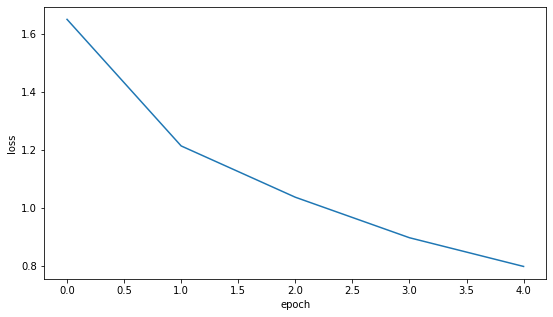

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot([loss.cpu().numpy() for loss in glob_loss])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Actually, with parameters not like mine, model is not training. With learning rate > 0.0001 loss is stucked next to 2.3 and does not move. Also, with weight decay > 0.0001 model isn't training. With learning rate < 0.00005, training goes very slowly, for example, with lr=0.00001 it is 0.01 loss improvement per epoch 

In [ ]:
f1_list = []
acc_list = []
model.eval()
for batch in eval_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        out = model(**batch)
    
    y_pred = torch.argmax(out.logits, dim=-1)
    f1_list.append(f1_score(y_pred.cpu().numpy(), batch['labels'].cpu().numpy(), average='weighted'))
    acc_list.append(accuracy_score(y_pred.cpu().numpy(), batch['labels'].cpu().numpy()))

print('f1 = ', np.mean(f1_list))
print('acc = ', np.mean(acc_list))

f1 =  0.601557382212144
acc =  0.6001984126984127


For better results, more epochs could be done.